In [105]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
%matplotlib inline

Here we start with simple cross-validation, no balancing (later will add balancing)

In [116]:
datadir = "../data"
savedir = "../saves/catboost"
if not os.path.exists(savedir):
    os.makedirs(savedir)
os.listdir(datadir)
df_train = pd.read_csv(os.path.join(datadir, "single_muts_train.csv"))
df_test = pd.read_csv(os.path.join(datadir, "single_muts_test.csv"))

# 1. Start with sequence-based prediction

In [49]:
sorted(set([x for xs in df_test.sequence for x in xs]))
#df_train[['sequence', "stabilityscore"]].values

['A',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y']

In [53]:
aa = """Alanine	Ala	A
Arginine	Arg	R
Asparagine	Asn	N
Aspartic Acid	Asp	D
Cysteine	Cys	C
Glutamic Acid	Glu	E
Glutamine	Gln	Q
Glycine	Gly	G
Histidine	His	H
Isoleucine	Ile	I
Leucine	Leu	L
Lysine	Lys	K
Methionine	Met	M
Phenylalanine	Phe	F
Proline	Pro	P
Serine	Ser	S
Threonine	Thr	T
Tryptophan	Trp	W
Tyrosine	Tyr	Y
Valine	Val	V"""

aadict = dict()
for line in aa.split("\n"):
    data = line.split()
    if len(data)< 3:
        continue
    name = " ".join(data[0:-2])
    l3, l1 = data[-2:]
    aadict[l1] = (name, l3)
aa = sorted(aadict)
aa2idx = {x: i for i, x in enumerate(aa)}

In [129]:
x_full_train = np.stack(df_train.sequence.apply(lambda xs: np.asarray([aa2idx[x] for x in xs])).values)
y_full_train = df_train.stabilityscore.values

x_full_test = np.stack(df_test.sequence.apply(lambda xs: np.asarray([aa2idx[x] for x in xs])).values)
y_full_test = df_test.stabilityscore.values

In [121]:
NFOLDS = 5
RANDOM_SEED = 42

SAVE_PREFIX = os.path.join(savedir, "catboost_kf_")
from sklearn.model_selection import KFold
from catboost import Pool, CatBoostRegressor


In [183]:
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=RANDOM_SEED)
cat_features=np.arange(x_full_train.shape[1])
NITERATIONS=1000

split_data = dict()
for fold, (train_index, test_index) in enumerate(kf.split(x_full_train)):
    split_data[fold] = (train_index, test_index)
    x_train = x_full_train[train_index]
    y_train = y_full_train[train_index]
    x_val = x_full_train[test_index]
    y_val = y_full_train[test_index]
    # next model-specific
    model = CatBoostRegressor(iterations=NITERATIONS, depth=2, learning_rate=1, loss_function='RMSE',
                              metric_period=NITERATIONS//10)
    #train the model
    model.fit(x_train, y_train, eval_set=(x_val, y_val))
    # make the prediction using the resulting model
    pred_train = model.predict(x_train)
    pred_val = model.predict(x_val)

    path = f"{SAVE_PREFIX}{fold}.cbm"
    model.save_model(path)
    # break


0:	learn: 0.2866895	test: 0.2870140	best: 0.2870140 (0)	total: 4.08ms	remaining: 4.08s
100:	learn: 0.2249830	test: 0.2405080	best: 0.2405080 (100)	total: 391ms	remaining: 3.48s
200:	learn: 0.2069536	test: 0.2304318	best: 0.2304318 (200)	total: 791ms	remaining: 3.15s
300:	learn: 0.1965464	test: 0.2255195	best: 0.2255195 (300)	total: 1.18s	remaining: 2.74s
400:	learn: 0.1879330	test: 0.2229624	best: 0.2229624 (400)	total: 1.54s	remaining: 2.3s
500:	learn: 0.1799412	test: 0.2170560	best: 0.2170560 (500)	total: 1.91s	remaining: 1.91s
600:	learn: 0.1744352	test: 0.2150486	best: 0.2150486 (600)	total: 2.31s	remaining: 1.53s
700:	learn: 0.1696970	test: 0.2142105	best: 0.2142105 (700)	total: 2.81s	remaining: 1.2s
800:	learn: 0.1660606	test: 0.2130308	best: 0.2130308 (800)	total: 3.35s	remaining: 832ms
900:	learn: 0.1623022	test: 0.2122430	best: 0.2122430 (900)	total: 3.79s	remaining: 417ms
999:	learn: 0.1588189	test: 0.2110461	best: 0.2110461 (999)	total: 4.17s	remaining: 0us

bestTest = 0.211

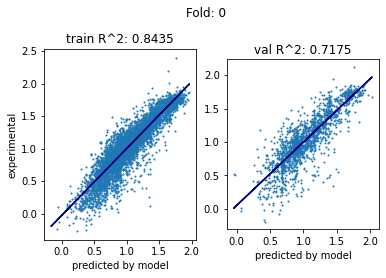

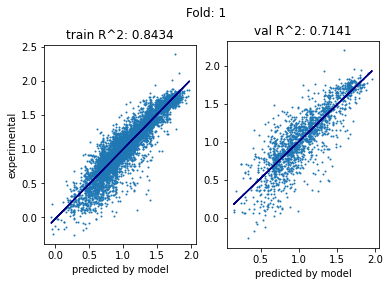

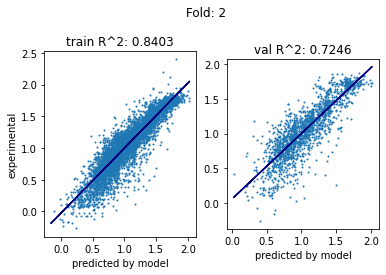

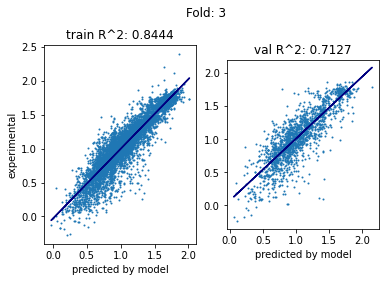

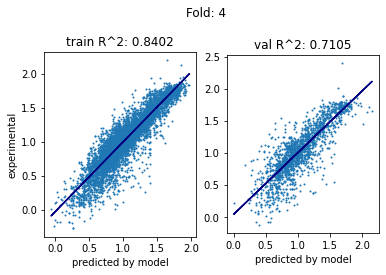

Train (using mean prediction) R^2= 0.8394436663439468
Train (using median prediction) R^2= 0.8433115525917224
Test (using mean prediction) R^2= 0.7255100212375992
Test (using median prediction) R^2= 0.7224002166666901


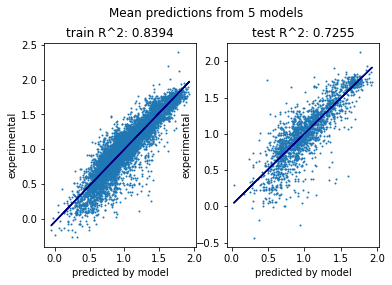

In [184]:
fold_predictions_train = []
fold_predictions_test = []
for fold in sorted(split_data):
    train_index, test_index = split_data[fold]
    x_train = x_full_train[train_index]
    y_train = y_full_train[train_index]
    x_val = x_full_train[test_index]
    y_val = y_full_train[test_index]

    path = f"{SAVE_PREFIX}{fold}.cbm"
    model = CatBoostRegressor()
    model.load_model(path)

    pred_train = model.predict(x_train)
    pred_val = model.predict(x_val)
    pred_full_train = model.predict(x_full_train)
    pred_full_test = model.predict(x_full_test)
    fold_predictions_train.append(pred_full_train)
    fold_predictions_test.append(pred_full_test)

    fig, (ax0, ax1) = plt.subplots(ncols=2)
    ax0.scatter(pred_train, y_train, s=1)
    
    score = r2_score(y_train, pred_train)
    m, b = np.polyfit(pred_train, y_train, 1)
    
    ax0.plot(pred_train, m*pred_train + b, color="navy")
    ax0.set_aspect("equal")
    ax0.set_title(f"train R^2: {score:.4f}")
    ax0.set_xlabel("predicted by model")
    ax0.set_ylabel("experimental")

    ax1.scatter(pred_val, y_val, s=1)
    m, b = np.polyfit(pred_val, y_val, 1)
    ax1.plot(pred_val, m*pred_val + b, color="navy")
    
    ax1.set_aspect("equal")
    score = r2_score(y_val, pred_val)
    ax1.set_title(f"val R^2: {score:.4f}");
    ax1.set_xlabel("predicted by model")
    plt.suptitle(f"Fold: {fold}")
    plt.show()
    plt.close(fig)

train_predictions_mean = np.stack(fold_predictions_train).mean(0)
test_predictions_mean = np.stack(fold_predictions_test).mean(0)
train_predictions_median = np.median(np.stack(fold_predictions_train), 0)
test_predictions_median = np.median(np.stack(fold_predictions_test), 0)

print("Train (using mean prediction) R^2=", r2_score(y_full_train, train_predictions_mean))
print("Train (using median prediction) R^2=", r2_score(y_full_train, train_predictions_median))

print("Test (using mean prediction) R^2=", r2_score(y_full_test, test_predictions_mean))
print("Test (using median prediction) R^2=", r2_score(y_full_test, test_predictions_median))

# the same plots for mean predictions - on train and test datasets:
fig, (ax0, ax1) = plt.subplots(ncols=2)
## train
ax0.scatter(train_predictions_mean, y_full_train, s=1)

score = r2_score(y_full_train, train_predictions_mean)
m, b = np.polyfit(train_predictions_mean, y_full_train, 1)

ax0.plot(train_predictions_mean, m*train_predictions_mean + b, color="navy")
ax0.set_aspect("equal")
ax0.set_title(f"train R^2: {score:.4f}")
ax0.set_xlabel("predicted by model")
ax0.set_ylabel("experimental")

## test
ax1.scatter(test_predictions_mean, y_full_test, s=1)

score = r2_score(y_full_test, test_predictions_mean)
m, b = np.polyfit(test_predictions_mean, y_full_test, 1)

ax1.plot(test_predictions_mean, m*test_predictions_mean + b, color="navy")
ax1.set_aspect("equal")
ax1.set_title(f"test R^2: {score:.4f}")
ax1.set_xlabel("predicted by model")
ax1.set_ylabel("experimental");
plt.suptitle(f"Mean predictions from {NFOLDS} models");

In [180]:
# in normal production setting cv is used just to search for model parameters,
# after that the model is trained on the whole train dataset.
# Let's compare our best model R^2 on test with the best ensemble.
# it won't be better than ensemble in the terms of performance, but it will run on new data faster.
model_all_data = CatBoostRegressor(
    iterations=NITERATIONS, depth=2, learning_rate=1, loss_function='RMSE',
    metric_period=NITERATIONS//10
)
model_all_data.fit(x_full_train, y_full_train, eval_set=(x_full_train, y_full_train))
path = f"{SAVE_PREFIX}all.cbm"
model_all_data.save_model(path)
predictions = model_all_data.predict(x_full_test)
score=r2_score(y_full_test, predictions)
print("R^2 score:", score)

0:	learn: 0.2867368	test: 0.2867368	best: 0.2867368 (0)	total: 3.46ms	remaining: 3.46s
100:	learn: 0.2258766	test: 0.2258766	best: 0.2258766 (100)	total: 361ms	remaining: 3.21s
200:	learn: 0.2081384	test: 0.2081384	best: 0.2081384 (200)	total: 779ms	remaining: 3.1s
300:	learn: 0.1959128	test: 0.1959128	best: 0.1959128 (300)	total: 1.18s	remaining: 2.73s
400:	learn: 0.1875329	test: 0.1875329	best: 0.1875329 (400)	total: 1.63s	remaining: 2.44s
500:	learn: 0.1817221	test: 0.1817221	best: 0.1817221 (500)	total: 2.07s	remaining: 2.06s
600:	learn: 0.1773392	test: 0.1773392	best: 0.1773392 (600)	total: 2.54s	remaining: 1.69s
700:	learn: 0.1728300	test: 0.1728300	best: 0.1728300 (700)	total: 2.92s	remaining: 1.25s
800:	learn: 0.1688050	test: 0.1688050	best: 0.1688050 (800)	total: 3.29s	remaining: 816ms
900:	learn: 0.1656628	test: 0.1656628	best: 0.1656628 (900)	total: 3.64s	remaining: 400ms
999:	learn: 0.1628713	test: 0.1628713	best: 0.1628713 (999)	total: 3.98s	remaining: 0us

bestTest = 0.16